In [1]:
import pandas as pd 
import numpy as np       
import seaborn as sns 
import matplotlib.pylab as plt  
from collections import Counter 
from imblearn.over_sampling import RandomOverSampler  
from sklearn.preprocessing import LabelEncoder

## Data Preprocessing

In [2]:
df = pd.read_csv('bank-direct-marketing-campaigns.csv') 
print(df.shape)  
df.head()

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df2 = df.drop(columns = ['pdays','day_of_week','campaign','previous','poutcome','pdays','contact','month'],axis=1) 

columns_to_filter = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Apply filtering using a for loop
df_filtered = df2.copy()
for column in columns_to_filter:
    df_filtered = df_filtered[df_filtered[column] != 'unknown']

# Print the resulting dataframe
df3 = pd.DataFrame(df_filtered)

In [4]:
binary_encode = {'yes': 1, 'no': 0}
df3['y'] = df3['y'].map(binary_encode) 
df3['default'] = df3['default'].map(binary_encode) 
df3['housing'] = df3['housing'].map(binary_encode) 
df3['loan'] = df3['loan'].map(binary_encode)

## Finding the Optimal Rankings to Ordinally Encode Categorical Features

In [5]:
education_encoder = {'basic.4y':2, 'high.school':5, 'basic.6y':3, 'professional.course':6,
       'basic.9y':4, 'university.degree':7, 'illiterate':1}  

df3['education'] = df3['education'].map(education_encoder) 

In [6]:
job_encoder = {'housemaid':1, 'services':6, 'admin.':11, 'technician':10, 'blue-collar':9,
       'unemployed':3, 'retired':8, 'entrepreneur':2, 'management':7, 'student':5,
       'self-employed':4}  

df3['job'] = df3['job'].map(job_encoder) 

In [7]:
marital_encoder = {'divorced':1,'single':2,'married':3} 
df3['marital'] = df3['marital'].map(marital_encoder)

## RandomOverSampling

In [8]:
#separating the X and the Y values
X = df3.drop(['y'], axis = 1) 
Y = df3["y"]    

# getting just the values for the sake of processing  
# (its a numpy array with no columns) 
xData = X.values 
yData = Y.values 

In [9]:
os =  RandomOverSampler(sampling_strategy = 0.8)
X_train_res, y_train_res = os.fit_resample(xData, yData)
print(" New 'x' has",X_train_res.shape,"        New 'Y' has",y_train_res.shape)
print('Original dataset shape {}'.format(Counter(yData)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))   

 New 'x' has (47932, 12)         New 'Y' has (47932,)
Original dataset shape Counter({0: 26629, 1: 3859})
Resampled dataset shape Counter({0: 26629, 1: 21303})


## Random Forest Classifier using RandomOverSampling

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix  

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res,y_train_res, test_size=0.2, random_state=42)

In [13]:
model = RandomForestClassifier() 
model.fit(X_train,y_train)

RandomForestClassifier()

In [14]:
y_pred = model.predict(X_test)

## Model Evaluation

In [15]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5308
           1       0.87      0.98      0.92      4279

    accuracy                           0.93      9587
   macro avg       0.93      0.93      0.93      9587
weighted avg       0.93      0.93      0.93      9587



In [18]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10) 
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score: {:.2f}%".format(cv_scores.mean()*100))

Cross-validation Scores: [0.91890482 0.92333768 0.92568449 0.92151239 0.93116037 0.92723005
 0.92801252 0.9246218  0.92357851 0.92279604]
Mean Cross-validation Score: 92.47%


In [17]:
roc_auc_score(y_test,y_pred)  

0.9321816531656943

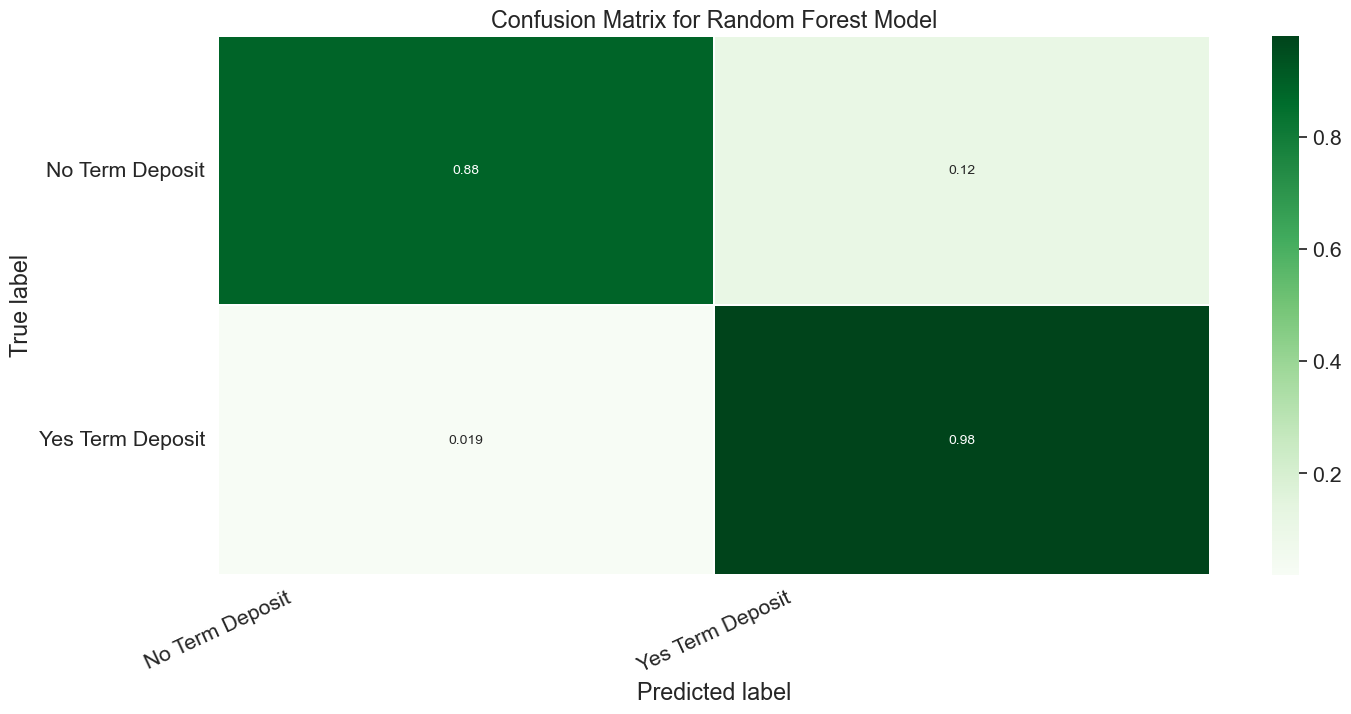

In [19]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ["No Term Deposit","Yes Term Deposit"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [20]:
importances = model.feature_importances_
columns = X.columns

i=0

while i < len(columns):
    print(f" The importance of feature '{columns[i]}' is {round(importances[i]*100, 2)}%")
    i +=1

 The importance of feature 'age' is 26.31%
 The importance of feature 'job' is 9.66%
 The importance of feature 'marital' is 3.85%
 The importance of feature 'education' is 7.28%
 The importance of feature 'default' is 0.0%
 The importance of feature 'housing' is 3.29%
 The importance of feature 'loan' is 2.3%
 The importance of feature 'emp.var.rate' is 4.6%
 The importance of feature 'cons.price.idx' is 3.0%
 The importance of feature 'cons.conf.idx' is 4.69%
 The importance of feature 'euribor3m' is 23.44%
 The importance of feature 'nr.employed' is 11.58%
